In [3]:
# Import the drive module
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications import ResNet50  # Changed to ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input  # ResNet preprocessing
from sklearn.metrics import classification_report, confusion_matrix
import PIL
import PIL.Image

In [5]:
# Load all the images
train_dir = "/content/drive/MyDrive/IND_Currency_Dataset/IND_Currency_Dataset/train"
test_dir = "/content/drive/MyDrive/IND_Currency_Dataset/IND_Currency_Dataset/test"
TARGET_SIZE = 224
BATCH_SIZE = 64

In [6]:
# Data augmentation with ResNet preprocessing
train_datagen = ImageDataGenerator(
    validation_split=0.2,
    preprocessing_function=preprocess_input  # Changed to ResNet's preprocessing
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset="training",
    shuffle=True,
    target_size=(TARGET_SIZE, TARGET_SIZE)
)

print(train_generator.class_indices)


Found 1939 images belonging to 2 classes.
{'fake': 0, 'real': 1}


In [7]:
# Using ResNet50 model for training
base_model = ResNet50(
    weights='imagenet',
    input_shape=(TARGET_SIZE, TARGET_SIZE, 3),
    include_top=False  # Remove original classification layers
)
base_model.trainable = False  # Freeze base layers

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset="validation",
    shuffle=False,
    target_size=(TARGET_SIZE, TARGET_SIZE)
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Found 484 images belonging to 2 classes.


In [8]:
# Custom model head for ResNet
inputs = tf.keras.Input(shape=(TARGET_SIZE, TARGET_SIZE, 3))
x = base_model(inputs, training=False)  # Important for fine-tuning later
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)  # Increased units for ResNet
x = tf.keras.layers.Dropout(0.5)(x)  # Added dropout for regularization
output = tf.keras.layers.Dense(len(train_generator.class_indices), activation='softmax')(x)

resnet_model = tf.keras.Model(inputs=inputs, outputs=output)
resnet_model.summary()

# Compile the model
opt = tf.keras.optimizers.Adam(learning_rate=1e-4)  # Lower initial learning rate
cce = tf.keras.losses.CategoricalCrossentropy()
resnet_model.compile(optimizer=opt, loss=cce, metrics=['accuracy'])

# Define callbacks (same as before)
checkpoint_filepath = 'resnet_model.weights.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,112,770 (91.98 MB)

 Trainable params: 525,058 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [9]:
# Test generator with ResNet preprocessing
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    target_size=(TARGET_SIZE, TARGET_SIZE),
    shuffle=False
)

# Metrics tracking lists (same as before)
train_acc_per_epoch = []
val_acc_per_epoch = []
train_loss_per_epoch = []
val_loss_per_epoch = []
test_acc_per_epoch = []
test_loss_per_epoch = []

EPOCHS = 10
NUM_STEPS = train_generator.samples // BATCH_SIZE
VAL_NUM_STEPS = validation_generator.samples // BATCH_SIZE

# Training loop (same structure)
for epoch in range(EPOCHS):
    history = resnet_model.fit(
        train_generator,
        epochs=1,
        steps_per_epoch=NUM_STEPS,
        validation_data=validation_generator,
        validation_steps=VAL_NUM_STEPS,
        callbacks=[reduce_lr, model_checkpoint_callback]
    )

    # Store metrics
    train_acc_per_epoch.append(history.history['accuracy'][0])
    val_acc_per_epoch.append(history.history['val_accuracy'][0])
    train_loss_per_epoch.append(history.history['loss'][0])
    val_loss_per_epoch.append(history.history['val_loss'][0])

    # Test evaluation
    test_loss, test_accuracy = resnet_model.evaluate(test_generator, steps=test_generator.samples // BATCH_SIZE)
    test_acc_per_epoch.append(test_accuracy)
    test_loss_per_epoch.append(test_loss)

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Found 177 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


30/30 ━━━━━━━━━━━━━━━━━━━━ 199s 5s/step - accuracy: 0.6975 - loss: 0.9992 - val_accuracy: 0.8438 - val_loss: 0.3926 - learning_rate: 1.0000e-04
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 699ms/step - accuracy: 0.8021 - loss: 0.4307
Epoch 1/10
Test Loss: 0.3450, Test Accuracy: 0.8516
30/30 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.8981 - loss: 0.2410 - val_accuracy: 0.8438 - val_loss: 0.3810 - learning_rate: 1.0000e-04
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/step - accuracy: 0.9271 - loss: 0.1960
Epoch 2/10
Test Loss: 0.1513, Test Accuracy: 0.9453
30/30 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9653 - loss: 0.1091 - val_accuracy: 0.8058 - val_loss: 0.4649 - learning_rate: 1.0000e-04
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 967ms/step - accuracy: 0.9479 - loss: 0.1234
Epoch 3/10
Test Loss: 0.0954, Test Accuracy: 0.9609
30/30 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9817 - loss: 0.0713 - val_accuracy: 0.8103 - val_loss: 0.4505 - learning_rate: 1.0000e-04
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 657ms/step - accuracy: 0

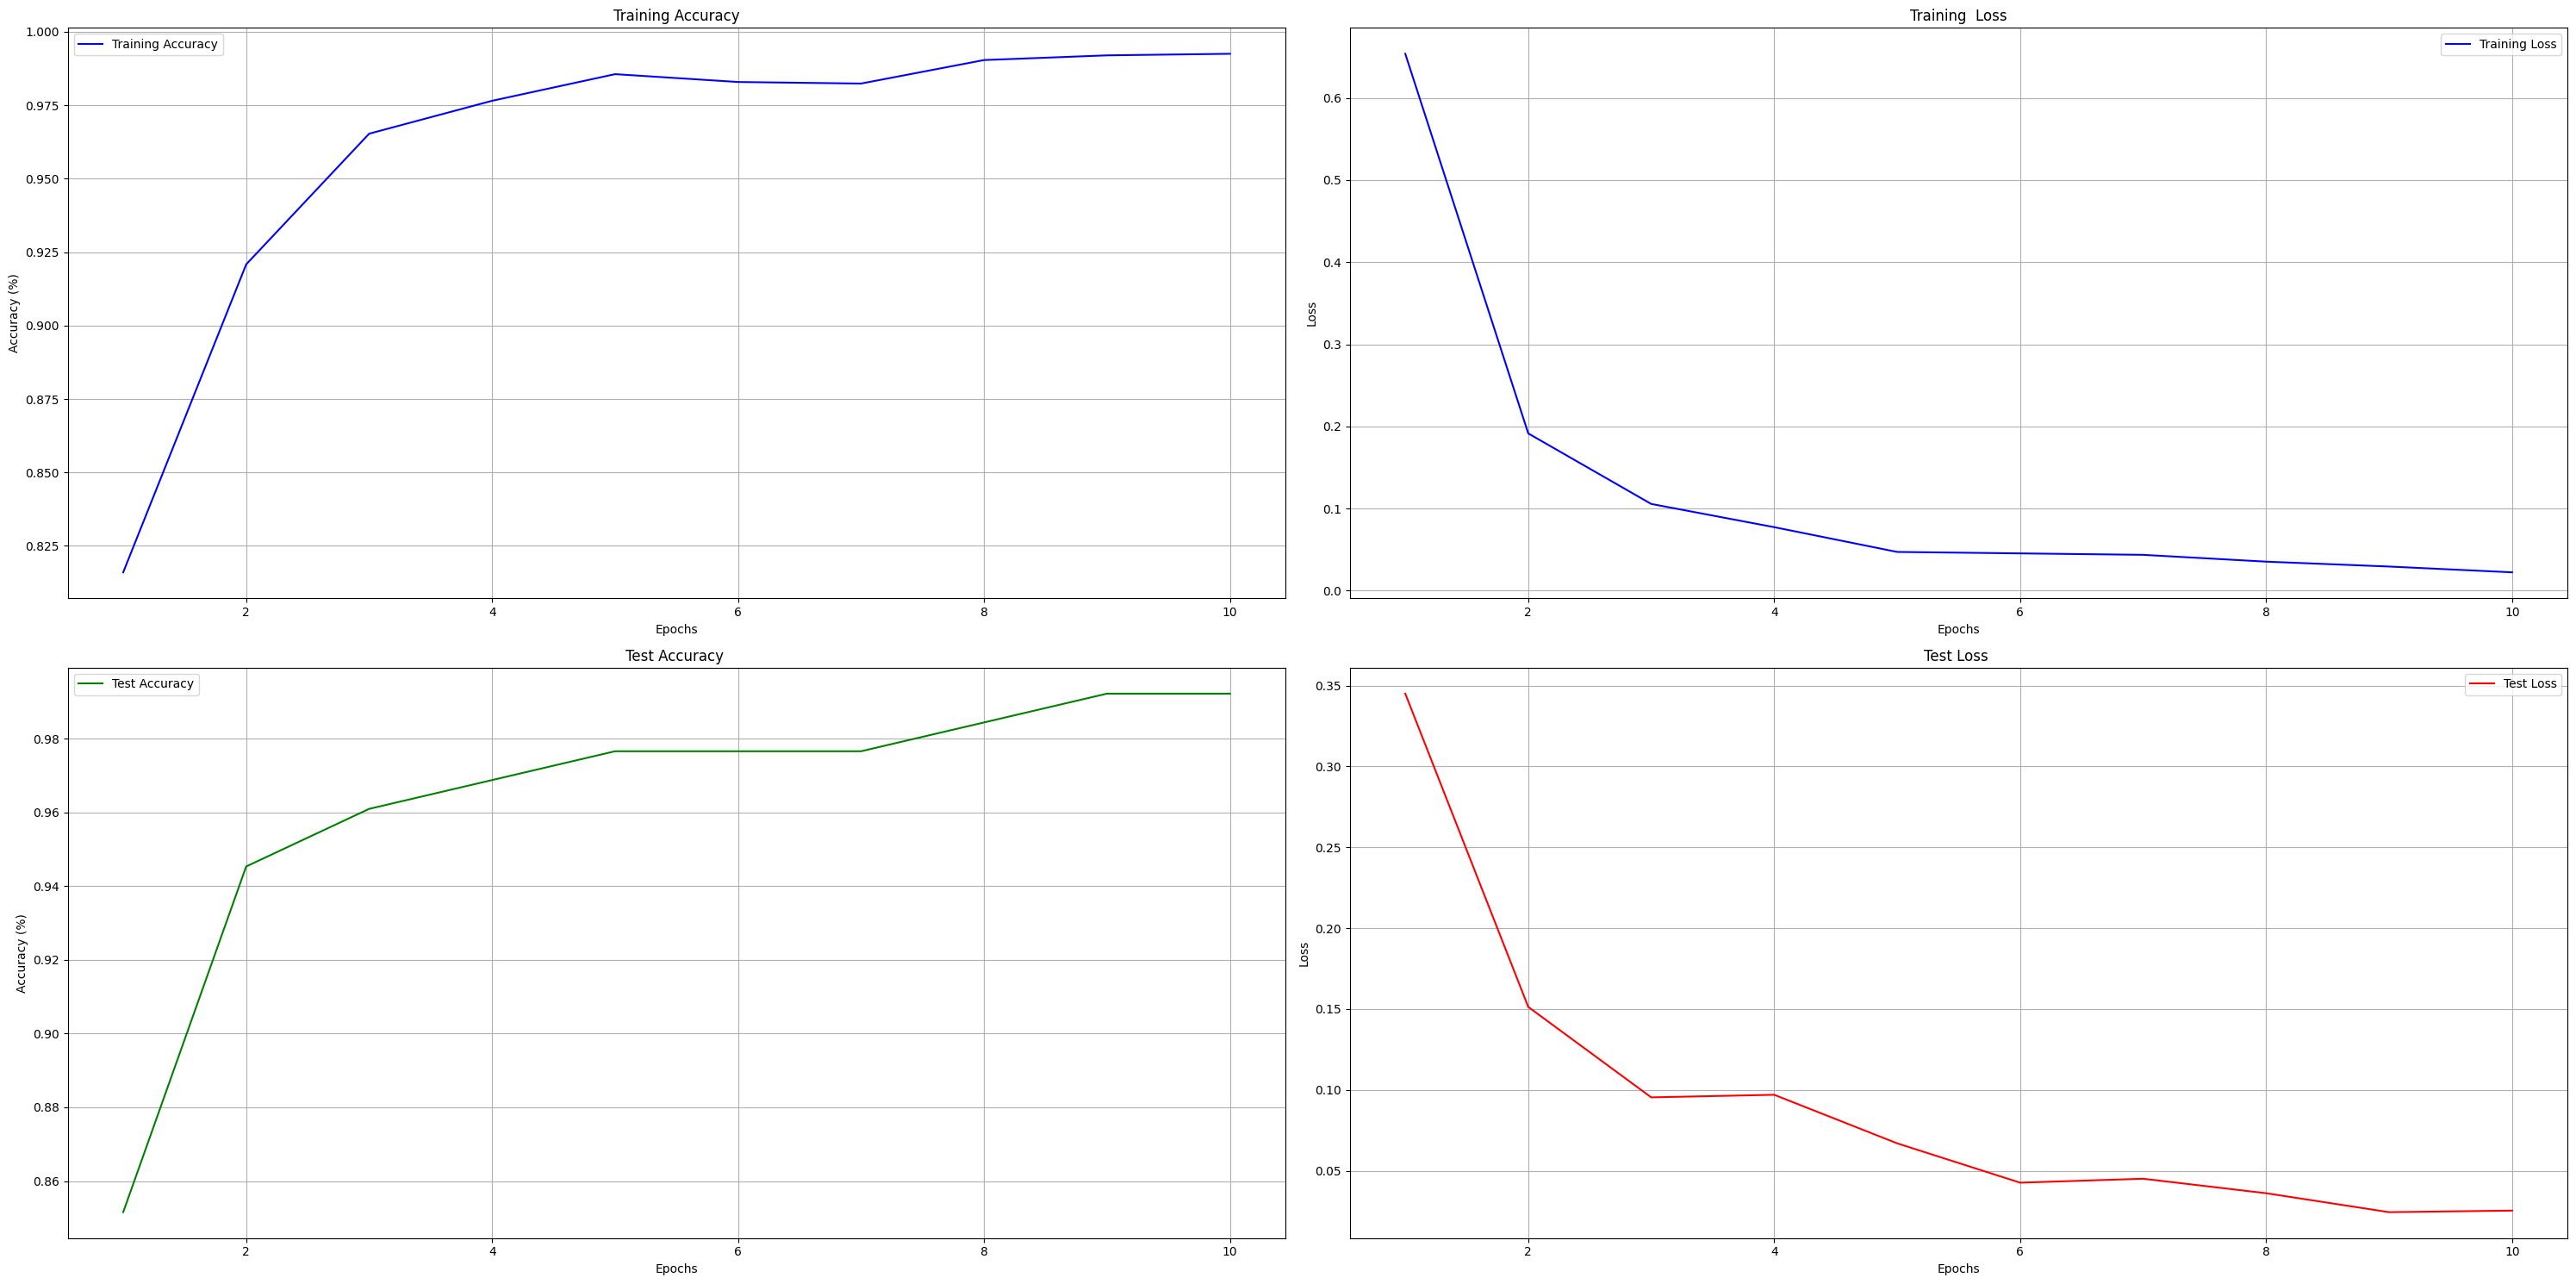

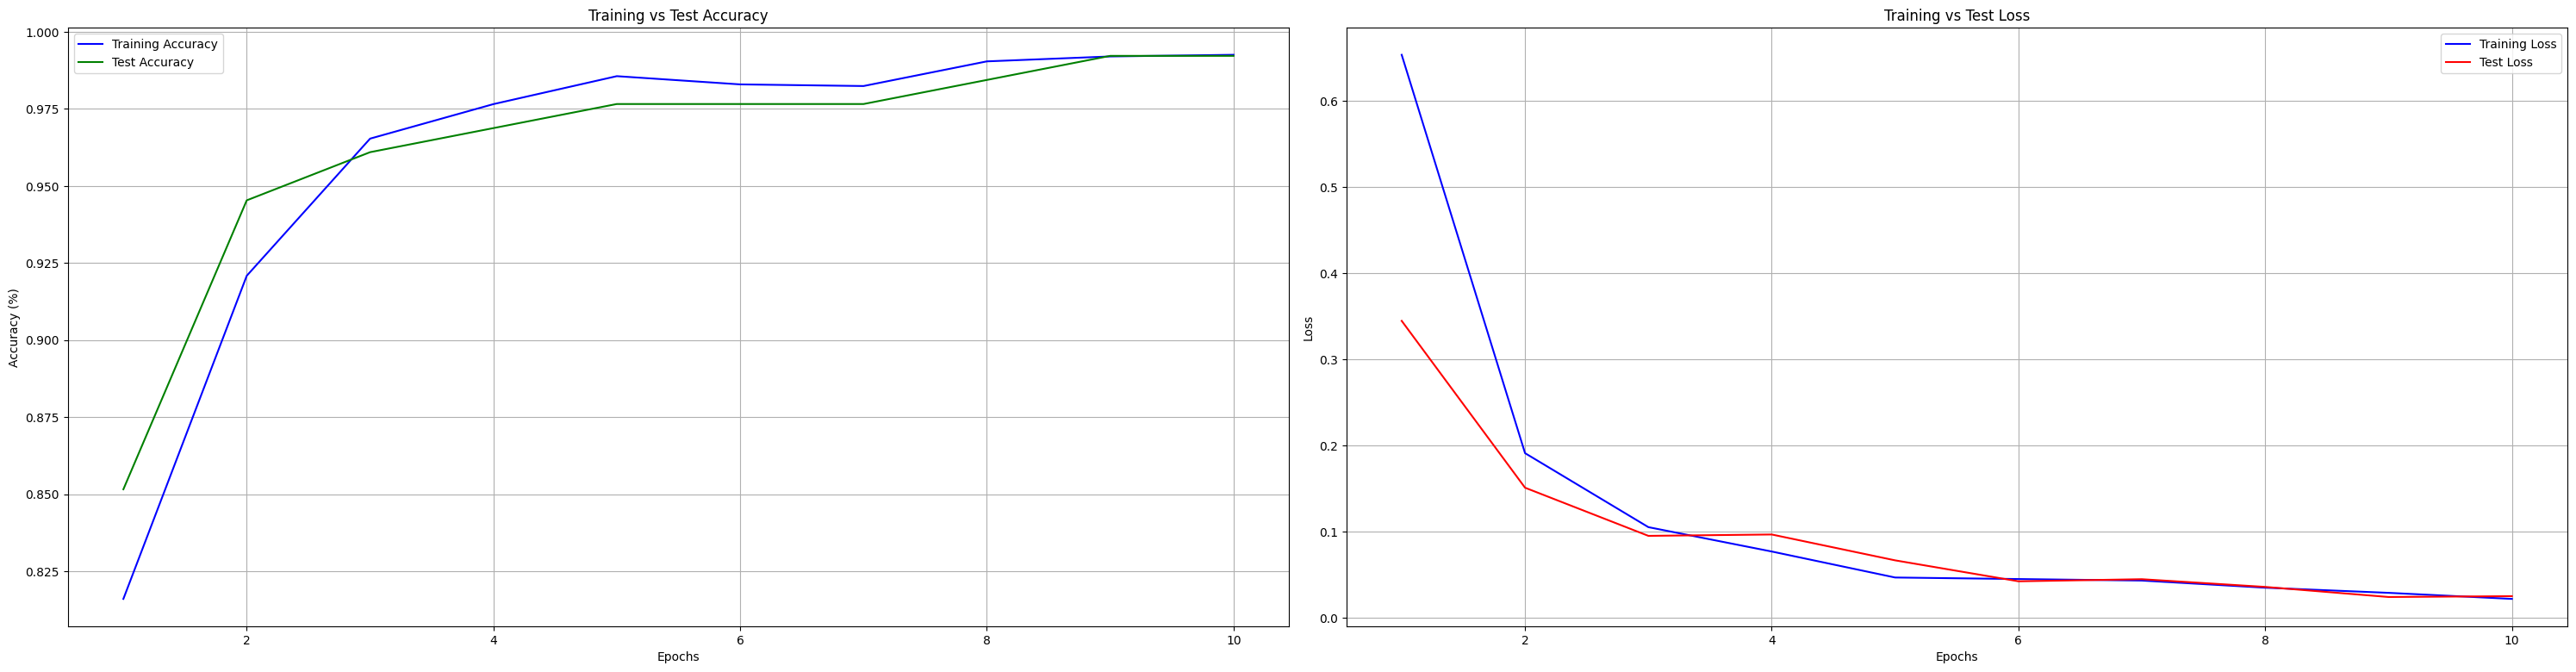

Final Model Loss: 0.0222
Final Model Accuracy: 0.9925


In [11]:
# Plot 1: Training vs Validation Accuracy
plt.figure(figsize=(30, 15))

plt.subplot(2, 2, 1)
plt.plot(range(1, EPOCHS+1), train_acc_per_epoch, label='Training Accuracy', color='blue')
#plt.plot(range(1, EPOCHS+1), val_acc_per_epoch, label='Validation Accuracy', color='orange')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid()

# Plot 2: Training vs Validation Loss
plt.subplot(2, 2, 2)
plt.plot(range(1, EPOCHS+1), train_loss_per_epoch, label='Training Loss', color='blue')
#plt.plot(range(1, EPOCHS+1), val_loss_per_epoch, label='Validation Loss', color='orange')
plt.title('Training  Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# Plot 3: Test Accuracy per Epoch
plt.subplot(2, 2, 3)
plt.plot(range(1, EPOCHS+1), test_acc_per_epoch, label='Test Accuracy', color='green')
plt.title('Test Accuracy ')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid()

# Plot 4: Test Loss per Epoch
plt.subplot(2, 2, 4)
plt.plot(range(1, EPOCHS+1), test_loss_per_epoch, label='Test Loss', color='red')
plt.title('Test Loss ')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()
plt.figure(figsize=(30, 15))

# Plot 5: Training vs Test Accuracy
plt.subplot(2, 2, 3)
plt.plot(range(1, EPOCHS+1), train_acc_per_epoch, label='Training Accuracy', color='blue')
plt.plot(range(1, EPOCHS+1), test_acc_per_epoch, label='Test Accuracy', color='green')
plt.title('Training vs Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid()

# Plot 6: Training vs Test Loss
plt.subplot(2, 2, 4)
plt.plot(range(1, EPOCHS+1), train_loss_per_epoch, label='Training Loss', color='blue')
plt.plot(range(1, EPOCHS+1), test_loss_per_epoch, label='Test Loss', color='red')
plt.title('Training vs Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# Adjust layout to ensure all plots fit nicely
plt.tight_layout()

# Show the plots
plt.show()

# Print final model loss and accuracy
final_loss = history.history['loss'][-1]  # Final training loss (from the last epoch)
final_accuracy = history.history['accuracy'][-1]  # Final training accuracy (from the last epoch)


# Print final model loss and accuracy
final_loss = history.history['loss'][-1]
final_accuracy = history.history['accuracy'][-1]
print(f'Final Model Loss: {final_loss:.4f}')
print(f'Final Model Accuracy: {final_accuracy:.4f}')
